# <font color='red'>**Sequence to sequence implementation**</font>

In [ ]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.layers import Input, Softmax, RNN, Dense, Embedding, LSTM

import unicodedata
import re
import numpy as np
import os
from tqdm import tqdm


<font color='blue'>**Load the data**</font>

In [ ]:
#### Referencce 
#### https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/26. Attention Models (italian to english )/ita-eng

/content/drive/My Drive/26. Attention Models (italian to english )/ita-eng


In [ ]:
data_path = '/content/drive/My Drive/26. Attention Models (italian to english )/ita-eng/ita.txt'

In [ ]:
data  = open(data_path,encoding='UTF-8').read().strip().split('\n')

<font color='blue'>**Preprocess data**</font>

In [ ]:
file = open(data_path, 'r', encoding = "utf8")
data = []

for line in tqdm(file):
    pos = line.find("CC-BY")
    line = line[:pos-1]
    
    # Split the data into english and Italian
    eng, ita = line.split('\t')
    
    # form tuples of the data
    text = eng, ita
    data.append(text)
    
file.close()

340432it [00:00, 636546.35it/s]


In [ ]:
raw_data_en, raw_data_it = list(zip(*data))
raw_data_en, raw_data_it = list(raw_data_en), list(raw_data_it)

In [ ]:
lang = pd.DataFrame(columns=['Italian','English'])

lang['Italian'] = raw_data_it
lang['English'] = raw_data_en

lang.head(1)

,Italian,English
0,Ciao!,Hi.


In [ ]:
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  w = re.sub(r"[^a-zA-Z?.!,¿']+", " ", w)

  w = w.strip()
  
  w = '<start>'+' ' + w +' '+ '<end>'
  return w

In [ ]:
lang['Italian'] = lang['Italian'].apply(preprocess_sentence)
lang['English'] = lang['English'].apply(preprocess_sentence)
lang.head(-1)

,Italian,English
0,<start> ciao ! <end>,<start> hi . <end>
1,<start> corri ! <end>,<start> run ! <end>
2,<start> corra ! <end>,<start> run ! <end>
3,<start> correte ! <end>,<start> run ! <end>
4,<start> chi ? <end>,<start> who ? <end>
...,...,...
340426,"<start> se vuoi sembrare un madrelingua , devi...",<start> if you want to sound like a native spe...
340427,"<start> se vuoi sembrare un madrelingua , devi...",<start> if you want to sound like a native spe...
340428,"<start> se vuoi sembrare un madrelingua , devi...",<start> if you want to sound like a native spe...
340429,<start> se qualcuno che non conosce il tuo bac...,<start> if someone who doesn't know your backg...


In [ ]:
lang.to_pickle('/content/drive/My Drive/26. Attention Models (italian to english )/text_data.pkl')

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

<font color='blue'>**Encoder**</font>

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,enc_units,input_length):

        #Initialize Embedding layer
        #Intialize Encoder LSTM layer
        super().__init__()
        self.inp_vocab_size  = inp_vocab_size
        self.embedding_size = embedding_size
        self.input_length = input_length 
        self.enc_units = enc_units
        self.embedding = Embedding(input_dim = self.inp_vocab_size,output_dim = self.embedding_size,input_length = self.input_length, mask_zero = 0, name = 'embedding_layer')
        self.lstm = LSTM(self.enc_units , return_sequences = True , return_state = True)


    def call(self,input_sequence,states):

      '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
      '''
     
      input_sentence = self.embedding(input_sequence)
      lstm_output,state_h,state_c = self.lstm(input_sentence,initial_state=states)

      return lstm_output,state_h,state_c




    def initialize_states(self,batch_size):
      '''
      Given a batch size it will return intial hidden state and intial cell state.
      If batch size is 32- Hidden state shape is [32,lstm_units], cell state shape is [32,lstm_units]

      '''
      self.batch_size = batch_size
      return (tf.zeros([batch_size,self.enc_units]),
             tf.zeros([batch_size,self.enc_units]))
      


<font color='cyan'>**Grader function - 1**</font>

In [ ]:
def grader_check_encoder():
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class the calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''


  def __init__(self,scoring_function, att_units):
    super(Attention,self).__init__()
    self.scoring_function = scoring_function
# Please go through the reference notebook and research paper to complete the scoring functions

    if self.scoring_function=='dot':
      pass  
    if scoring_function == 'general':
    # Intialize variables needed for General score function here
      self.W1 = tf.keras.layers.Dense(att_units)
      pass
    elif scoring_function == 'concat':
    # Intialize variables needed for Concat score function here
      self.W1 = tf.keras.layers.Dense(att_units)
      self.W2 = tf.keras.layers.Dense(att_units)
      self.V = tf.keras.layers.Dense(1)
      pass

    
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    if self.scoring_function == 'dot':
    # Implement Dot score function here
      query_with_time_axis = tf.expand_dims(decoder_hidden_state,-1)  ## Adding one dimension at the end
      score = tf.matmul(encoder_output,query_with_time_axis) 
      attention_weight = tf.nn.softmax(score,axis=1)
      context_vector = attention_weight*encoder_output
      context_vector = tf.reduce_sum(context_vector,axis=1)
      pass

    if self.scoring_function == 'general':
      #Implement General score function 
      query_with_time_axis = tf.expand_dims(decoder_hidden_state,-1)
      score = self.W1(encoder_output)
      score = tf.matmul(score,query_with_time_axis)
      attention_weight = tf.nn.softmax(score,axis=1)
      context_vector = attention_weight*encoder_output
      context_vector = tf.reduce_sum(context_vector,axis=1)

      
      pass

    elif self.scoring_function == 'concat':
    # Implement General score function here

      query_with_time_axis = tf.expand_dims(decoder_hidden_state,1)
      score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(encoder_output)))
      attention_weight = tf.nn.softmax(score,axis=1)
      context_vector = attention_weight* encoder_output
      context_vector = tf.reduce_sum(context_vector,axis=1)

      pass

    
    return context_vector,attention_weight




    
    

<font color='cyan'>**Grader function - 2**</font>

In [ ]:
def grader_check_attention(scoring_fun):
    input_length=10
    vocab_size=10
    batch_size=16
    att_units=32
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))

True
True
True


<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class OneStepDecoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
      super(OneStepDecoder,self).__init__()
      # Initialize decoder embedding layer, LSTM and any other objects needed
      self.embedding = tf.keras.layers.Embedding(tar_vocab_size,embedding_dim)
      self.lstm = tf.keras.layers.LSTM(dec_units,
                                   return_state=True,
                                   return_sequences = True,
                                   recurrent_initializer='glorot_uniform')
      
      self.dense = tf.keras.layers.Dense(tar_vocab_size)
      



      ##Used for attention model
      self.attention = Attention(score_fun,att_units)



  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanisim step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(1,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''
    
    output = self.embedding(input_to_decoder)
    context_vector,attention_weight = self.attention.call(state_h,encoder_output)
    concatenated = tf.concat([tf.expand_dims(context_vector, 1), output], axis=-1)
    decoder_output,state_h,state_c =  self.lstm(concatenated,initial_state = [state_h,state_c])
    decoder_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
    output = self.dense(decoder_output)

    return output,state_h,state_c,attention_weight,context_vector

    
    


<font color='cyan'>**Grader function - 3**</font>

In [ ]:
def grader_onestepdecoder(score_fun):
    vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=OneStepDecoder(vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)

    assert(output.shape==(batch_size,vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))
    

True
True
True


<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, output_length, dec_units ,score_fun ,att_units):
      super(Decoder,self).__init__()
      self.vocab_size = out_vocab_size
      self.embedding_dim = embedding_dim
      self.output_length = output_length
      self.score_fun = score_fun
      self.dec_units=dec_units
      self.att_units = att_units
      #Intialize necessary variables and create an object from the class onestepdecoder
      self.onestepdecoder = OneStepDecoder(self.vocab_size, self.embedding_dim, self.output_length, self.dec_units ,self.score_fun ,self.att_units)

  
    @tf.function   
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state ):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        all_output = tf.TensorArray(tf.float32,size=input_to_decoder.shape[1],name='output_arrays')

        

        
        #Iterate till the length of the decoder input
        for timestep in range(input_to_decoder.shape[1]):
          
          # Call onestepdecoder for each token in decoder_input
         
          output,decoder_hidden_state ,decoder_cell_state,attention_weights,context_vector = self.onestepdecoder.call(input_to_decoder[:,timestep:timestep+1], encoder_output,decoder_hidden_state,decoder_cell_state)
          # Store the output in tensorarray
          
          all_output = all_output.write(timestep,output)

        # Return the tensor array
        all_output = tf.transpose(all_output.stack(),[1,0,2])

        return all_output
        
        
    

<font color='cyan'>**Grader function - 4**</font>

In [ ]:
def grader_decoder(score_fun):
    out_vocab_size=13 
    embedding_dim=12 
    input_length=10
    output_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,output_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, output_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,output_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self,input_vocab_size,embedding_size,lstm_size,inp_len,out_vocab_size,out_len, dec_unit ,score ,att_unit):
    super().__init__()
    #Intialize objects from encoder decoder
    self.encoder = Encoder(inp_vocab_size=input_vocab_size,embedding_size=300,enc_units=lstm_size,input_length=inp_len)
    self.decoder = Decoder(out_vocab_size=out_vocab_size,embedding_dim=300,output_length=out_len,dec_units=dec_unit,score_fun=score,att_units=att_unit)
    # self.dense = tf.keras.layers.Dense(out_vocab_size, activation = 'softmax')
    # self.input_vocab_size = input_vocab_size




  
  def call(self,data):
    input ,output = data[0],data[1]
    #Intialize encoder states, Pass the encoder_sequence to the embedding layer
    initital_state = self.encoder.initialize_states(64)
    encoder_output,encoder_state_h,encoder_state_c = self.encoder(input,initital_state)
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder



    decoder_output = self.decoder(output,encoder_output,encoder_state_h,encoder_state_c)
    # return the decoder output
    # output = self.dense(decoder_output)
    return decoder_output 



<font color='blue'>**Custom loss function**</font>

In [ ]:

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)


  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)


<font color='blue'>**Training**</font>

Implement dot function here.

In [ ]:
# Implement teacher forcing while training your model. You can do it two ways.
# Prepare your data, encoder_input,decoder_input and decoder_output
# if decoder input is 
# <start> Hi how are you
# decoder output should be
# Hi How are you <end>
# i.e when you have send <start>-- decoder predicted Hi, 'Hi' decoder predicted 'How' .. e.t.c

# or
 
# model.fit([train_ita,train_eng],train_eng[:,1:]..)
# Note: If you follow this approach some grader functions might return false and this is fine.

In [ ]:
## Making of data 
data = pd.read_pickle('/content/drive/My Drive/26. Attention Models (italian to english )/text_data.pkl')


In [ ]:
data = data[:100000]

In [ ]:
data.head(-1)

,Italian,English
0,<start> ciao ! <end>,<start> hi . <end>
1,<start> corri ! <end>,<start> run ! <end>
2,<start> corra ! <end>,<start> run ! <end>
3,<start> correte ! <end>,<start> run ! <end>
4,<start> chi ? <end>,<start> who ? <end>
...,...,...
99994,<start> io sono d'accordo col suo piano . <end>,<start> i agree with his plan . <end>
99995,<start> sono d'accordo col suo piano . <end>,<start> i agree with his plan . <end>
99996,<start> mi sento gia meglio . <end>,<start> i already feel better . <end>
99997,<start> io mi sento gia meglio . <end>,<start> i already feel better . <end>


In [ ]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer()
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [ ]:
input_data, inp_lang_tokenizer = tokenize(data['Italian'])
target_data, targ_lang_tokenizer = tokenize(data['English'])

In [ ]:
inp_lang_tokenizer.word_index['<start>'] = inp_lang_tokenizer.word_index['start']
del inp_lang_tokenizer.word_index['start']

In [ ]:
max_length_targ, max_length_inp = target_data.shape[1], input_data.shape[1]
max_length_targ,max_length_inp

(9, 19)

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_data, target_data, test_size=0.30)

print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

70000 70000 30000 30000


In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE


vocab_inp_size = len(inp_lang_tokenizer.word_index)+1
vocab_tar_size = len(targ_lang_tokenizer.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
dataset

<BatchDataset shapes: ((64, 19), (64, 9)), types: (tf.int32, tf.int32)>

## Training 

In [ ]:
!rm -rf logs 

In [ ]:
c_path = "/content/drive/My Drive/26. Attention Models (italian to english )/checkpoint"

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=c_path,monitor='val_loss',verbose=1,save_weights_only=True)

!mkdir "/content/drive/My Drive/26. Attention Models (italian to english )/logs"
t_path = "/content/drive/My Drive/26. Attention Models (italian to english )/logs"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=t_path,histogram_freq=1)


mkdir: cannot create directory ‘/content/drive/My Drive/26. Attention Models (italian to english )/logs’: File exists


In [ ]:
score_fun = 'dot'
inp_vocab_size = len(inp_lang_tokenizer.word_index) + 1
out_vocab_size = len(targ_lang_tokenizer.word_index) + 1
att_units = 128
input_length =19
output_length = 9
encoder_units = 128
decoder_units = 128
attention_units = 128
embedding = 300
model = encoder_decoder(inp_vocab_size,300,encoder_units,input_length,out_vocab_size,output_length,decoder_units,score_fun,attention_units)


In [ ]:
optimizer   = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')
model.compile(optimizer=optimizer, loss=loss_function)


In [ ]:
## Taking output from Class as layers of encoder and decoder 
print(model.layers[0]) ## We can get the output of encoder from layer1
print(model.layers[1]) ##   We can get the output of decoder from layer2 


In [ ]:
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir = '/content/drive/My Drive/26. Attention Models (italian to english )/training_checkpoint'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=model.layers[0],
                                 decoder=model.layers[1])

In [ ]:
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden,enc_state = model.layers[0](inp, enc_hidden)


    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions = model.layers[1](dec_input,enc_output,enc_hidden,enc_state)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = model.layers[0].trainable_variables + model.layers[1].trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss




In [ ]:
import time
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = model.layers[0].initialize_states(64)
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    
      


Epoch 1 Batch 0 Loss 4.4160
Epoch 1 Batch 100 Loss 2.6696
Epoch 1 Batch 200 Loss 2.6294
Epoch 1 Batch 300 Loss 2.3739
Epoch 1 Batch 400 Loss 2.2217
Epoch 1 Batch 500 Loss 2.2432
Epoch 1 Batch 600 Loss 2.3119
Epoch 1 Batch 700 Loss 2.0976
Epoch 1 Batch 800 Loss 2.0887
Epoch 1 Batch 900 Loss 2.0439
Epoch 1 Batch 1000 Loss 1.9560
Epoch 1 Loss 2.3154
Time taken for 1 epoch 179.93755888938904 sec

Epoch 2 Batch 0 Loss 1.9942
Epoch 2 Batch 100 Loss 1.9066
Epoch 2 Batch 200 Loss 1.9704
Epoch 2 Batch 300 Loss 1.9958
Epoch 2 Batch 400 Loss 1.9673
Epoch 2 Batch 500 Loss 1.9439
Epoch 2 Batch 600 Loss 2.0024
Epoch 2 Batch 700 Loss 1.8889
Epoch 2 Batch 800 Loss 1.8449
Epoch 2 Batch 900 Loss 1.7944
Epoch 2 Batch 1000 Loss 1.7105
Epoch 2 Loss 1.8920
Time taken for 1 epoch 177.9980800151825 sec

Epoch 3 Batch 0 Loss 1.7706
Epoch 3 Batch 100 Loss 1.7130
Epoch 3 Batch 200 Loss 1.6270
Epoch 3 Batch 300 Loss 1.6106
Epoch 3 Batch 400 Loss 1.5946
Epoch 3 Batch 500 Loss 1.6546
Epoch 3 Batch 600 Loss 1.4902
E

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
def plot_attention(attention_weight,sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention_weight, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

  
  

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  

  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence                                              
  '''
  attention_plot = np.zeros((output_length,input_length))
  preprocessed_sentence = preprocess_sentence(input_sentence)
  
  print(preprocessed_sentence)

  inputs = [inp_lang_tokenizer.word_index[i] for i in preprocessed_sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  enc_out, enc_hidden,enc_current = model.layers[0](inputs, [tf.zeros((1, encoder_units)),tf.zeros((1, encoder_units))])

  
  dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] , 0)

  for t in range(output_length):
    predictions,state_h,state_c, attention_weights,context_vector =model.layers[1].onestepdecoder(dec_input,
                                                         enc_out,enc_hidden,enc_current)
                                                        

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    print(predicted_id)

    result += targ_lang_tokenizer.index_word[predicted_id] + ' '

    print(result)

    if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, preprocessed_sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, preprocessed_sentence, attention_plot

  



In [ ]:
def translate(sentence):
  result, sent, attention_plot = predict(sentence)

  print('Input: %s' % (sent))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sent.split(' '))]
  plot_attention(attention_plot, sent.split(' '), result.split(' '))

  return sentence,result

<start> ciao <end>
1110
hi 
2
hi end 
Input: <start> ciao <end>
Predicted translation: hi end 


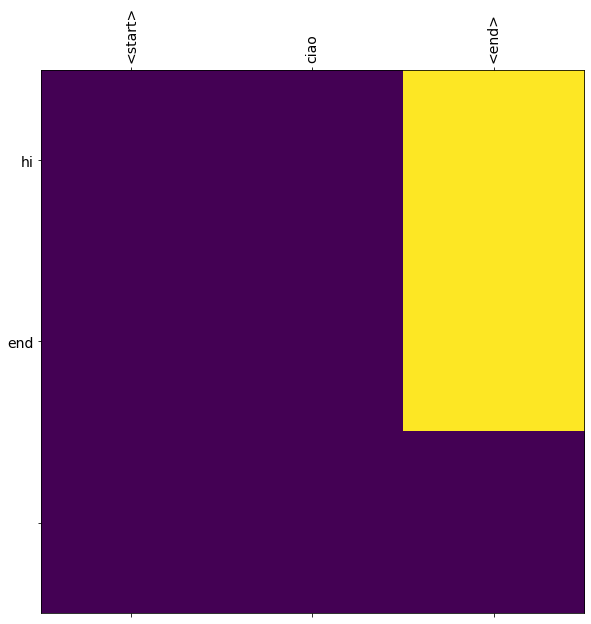

In [ ]:
sent,pred = translate('ciao')

In [ ]:
targ_lang_tokenizer.word_index['<end>']

2

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.                                         
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data                                 
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html
                                                                                
#Sample example                                                                 
import nltk.translate.bleu_score as bleu
score = 0
for i in range(1000):
  score = score + bleu.sentence_bleu(data['English'].iloc[i].split(' '), pred)

print(f'Final Bleu score :{score/1000}')

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(f'Final Bleu score :{score/1000}')

Final Bleu score :0.43597427246383813


<h3> Observation

<h4> Score function dot is giving bleu score of 0.44 for 1000 sentences with loss of 0.08 


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
score_fun = 'general'
inp_vocab_size = len(inp_lang_tokenizer.word_index) + 1
out_vocab_size = len(targ_lang_tokenizer.word_index) + 1
att_units = 128
input_length =19
output_length = 9
encoder_units = 128
decoder_units = 128
attention_units = 128
embedding = 300
model2 = encoder_decoder(inp_vocab_size,300,encoder_units,input_length,out_vocab_size,output_length,decoder_units,score_fun,attention_units)


In [ ]:
optimizer   = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')
model2.compile(optimizer=optimizer, loss=loss_function)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir2 = '/content/drive/My Drive/26. Attention Models (italian to english )/training_checkpoint2'
checkpoint_prefix2 = os.path.join(checkpoint_dir2, "ckpt")
checkpoint2 = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=model2.layers[0],
                                 decoder=model2.layers[1])

In [ ]:
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden,enc_state = model2.layers[0](inp, enc_hidden)


    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions = model2.layers[1](dec_input,enc_output,enc_hidden,enc_state)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = model2.layers[0].trainable_variables + model2.layers[1].trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss


In [ ]:
import time
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = model2.layers[0].initialize_states(64)
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint2.save(file_prefix = checkpoint_prefix2)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.7968
Epoch 1 Batch 100 Loss 1.8221
Epoch 1 Batch 200 Loss 1.7937
Epoch 1 Batch 300 Loss 1.8566
Epoch 1 Batch 400 Loss 1.7431
Epoch 1 Batch 500 Loss 1.6255
Epoch 1 Batch 600 Loss 1.6939
Epoch 1 Batch 700 Loss 1.7127
Epoch 1 Batch 800 Loss 1.5821
Epoch 1 Batch 900 Loss 1.4251
Epoch 1 Batch 1000 Loss 1.4663
Epoch 1 Loss 1.6741
Time taken for 1 epoch 163.19747352600098 sec

Epoch 2 Batch 0 Loss 1.3652
Epoch 2 Batch 100 Loss 1.4298
Epoch 2 Batch 200 Loss 1.2699
Epoch 2 Batch 300 Loss 1.3220
Epoch 2 Batch 400 Loss 1.4221
Epoch 2 Batch 500 Loss 1.3607
Epoch 2 Batch 600 Loss 1.3553
Epoch 2 Batch 700 Loss 1.4359
Epoch 2 Batch 800 Loss 1.2377
Epoch 2 Batch 900 Loss 1.1956
Epoch 2 Batch 1000 Loss 1.3124
Epoch 2 Loss 1.3062
Time taken for 1 epoch 162.84054374694824 sec

Epoch 3 Batch 0 Loss 1.0930
Epoch 3 Batch 100 Loss 1.1443
Epoch 3 Batch 200 Loss 1.1314
Epoch 3 Batch 300 Loss 1.1586
Epoch 3 Batch 400 Loss 1.0120
Epoch 3 Batch 500 Loss 1.1037
Epoch 3 Batch 600 Loss 1.0450


In [ ]:
def plot_attention(attention_weight,sentence, predicted_sentence):
  #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate

  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention_weight, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  

  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence                                              
  '''
  attention_plot = np.zeros((output_length,input_length))
  preprocessed_sentence = preprocess_sentence(input_sentence)
  
  print(preprocessed_sentence)

  inputs = [inp_lang_tokenizer.word_index[i] for i in preprocessed_sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  enc_out, enc_hidden,enc_current = model2.layers[0](inputs, [tf.zeros((1, encoder_units)),tf.zeros((1, encoder_units))])

  
  dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] , 0)

  for t in range(output_length):
    predictions,state_h,state_c, attention_weights,context_vector =model2.layers[1].onestepdecoder(dec_input,
                                                         enc_out,enc_hidden,enc_current)
                                                        

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    print(predicted_id)

    result += targ_lang_tokenizer.index_word[predicted_id] + ' '

    print(result)

    if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, preprocessed_sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, preprocessed_sentence, attention_plot


In [ ]:
def translate(sentence):
  result, sent, attention_plot = predict(sentence)

  print('Input: %s' % (sent))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sent.split(' '))]
  plot_attention(attention_plot, sent.split(' '), result.split(' '))

  return sentence,result

<start> ciao <end>
2589
goodbye 
2
goodbye end 
Input: <start> ciao <end>
Predicted translation: goodbye end 


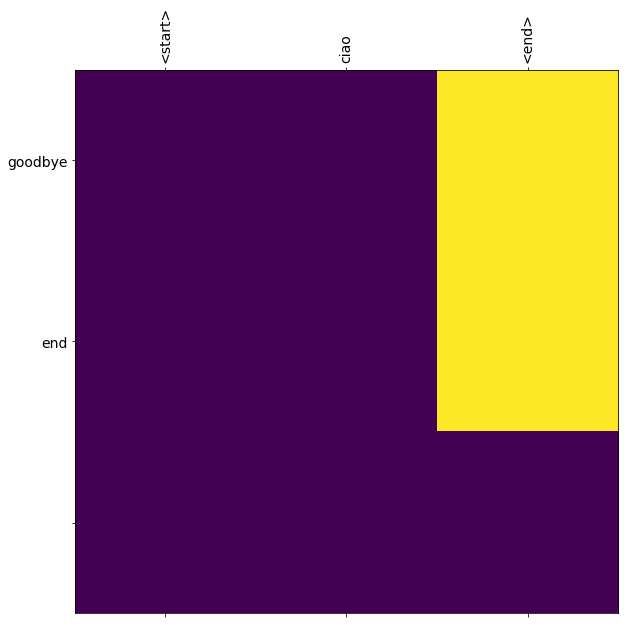

In [ ]:
sent,pred = translate('ciao')

In [ ]:
import nltk.translate.bleu_score as bleu
score = 0
for i in range(1000):
  score = score + bleu.sentence_bleu(data['English'].iloc[i].split(' '), pred)

final_score = score/1000

In [ ]:
print(f'Final Bleu score : {final_score}')

Final Bleu score : 0.4035820134


<h3> Observation 

<h4> Score function dot is giving bleu score of 0.41 for 1000 sentences with loss of 0.074

<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Write your observations on each of the scoring function

In [ ]:
score_fun = 'concat'
inp_vocab_size = len(inp_lang_tokenizer.word_index) + 1
out_vocab_size = len(targ_lang_tokenizer.word_index) + 1
att_units = 128
input_length =19
output_length = 9
encoder_units = 128
decoder_units = 128
attention_units = 128
embedding = 300
model3 = encoder_decoder(inp_vocab_size,300,encoder_units,input_length,out_vocab_size,output_length,decoder_units,score_fun,attention_units)


In [ ]:
optimizer   = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction='none')
model3.compile(optimizer=optimizer, loss=loss_function)

In [ ]:
optimizer = tf.keras.optimizers.Adam()
checkpoint_dir3= '/content/drive/My Drive/26. Attention Models (italian to english )/training_checkpoint'
checkpoint_prefix3 = os.path.join(checkpoint_dir3, "ckpt")
checkpoint3 = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=model3.layers[0],
                                 decoder=model3.layers[1])

In [ ]:
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden,enc_state = model3.layers[0](inp, enc_hidden)


    dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions = model3.layers[1](dec_input,enc_output,enc_hidden,enc_state)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = model3.layers[0].trainable_variables + model3.layers[1].trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [ ]:
import time
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = model3.layers[0].initialize_states(64)
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint3.save(file_prefix = checkpoint_prefix3)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.1131
Epoch 1 Batch 100 Loss 1.9314
Epoch 1 Batch 200 Loss 1.9500
Epoch 1 Batch 300 Loss 1.9493
Epoch 1 Batch 400 Loss 1.9632
Epoch 1 Batch 500 Loss 1.8059
Epoch 1 Batch 600 Loss 1.7760
Epoch 1 Batch 700 Loss 1.8158
Epoch 1 Batch 800 Loss 1.7736
Epoch 1 Batch 900 Loss 1.6640
Epoch 1 Batch 1000 Loss 1.6322
Epoch 1 Loss 1.8242
Time taken for 1 epoch 200.8970696926117 sec

Epoch 2 Batch 0 Loss 1.4983
Epoch 2 Batch 100 Loss 1.5095
Epoch 2 Batch 200 Loss 1.4773
Epoch 2 Batch 300 Loss 1.5811
Epoch 2 Batch 400 Loss 1.4559
Epoch 2 Batch 500 Loss 1.5614
Epoch 2 Batch 600 Loss 1.3068
Epoch 2 Batch 700 Loss 1.4137
Epoch 2 Batch 800 Loss 1.4599
Epoch 2 Batch 900 Loss 1.2698
Epoch 2 Batch 1000 Loss 1.3050
Epoch 2 Loss 1.4344
Time taken for 1 epoch 199.8168921470642 sec

Epoch 3 Batch 0 Loss 1.1549
Epoch 3 Batch 100 Loss 1.1672
Epoch 3 Batch 200 Loss 1.1383
Epoch 3 Batch 300 Loss 1.2165
Epoch 3 Batch 400 Loss 1.0761
Epoch 3 Batch 500 Loss 1.0542
Epoch 3 Batch 600 Loss 1.1279
Ep

In [ ]:
def predict(input_sentence):

  '''
  A. Given input sentence, convert the sentence into integers using tokenizer used earlier
  

  B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
  C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
  D. till we reach max_length of decoder or till the model predicted word <end>:
         predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
         Save the attention weights
         And get the word using the tokenizer(word index) and then store it in a string.
  E. Call plot_attention(#params)
  F. Return the predicted sentence                                              
  '''
  attention_plot = np.zeros((output_length,input_length))
  preprocessed_sentence = preprocess_sentence(input_sentence)
  
  print(preprocessed_sentence)

  inputs = [inp_lang_tokenizer.word_index[i] for i in preprocessed_sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=input_length,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  enc_out, enc_hidden,enc_current = model3.layers[0](inputs, [tf.zeros((1, encoder_units)),tf.zeros((1, encoder_units))])

  
  dec_input = tf.expand_dims([targ_lang_tokenizer.word_index['<start>']] , 0)

  for t in range(output_length):
    predictions,state_h,state_c, attention_weights,context_vector =model3.layers[1].onestepdecoder(dec_input,
                                                         enc_out,enc_hidden,enc_current)
                                                        

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    print(predicted_id)

    result += targ_lang_tokenizer.index_word[predicted_id] + ' '

    print(result)

    if targ_lang_tokenizer.index_word[predicted_id] == '<end>':
      return result, preprocessed_sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, preprocessed_sentence, attention_plot

In [ ]:
def translate(sentence):
  result, sent, attention_plot = predict(sentence)

  print('Input: %s' % (sent))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sent.split(' '))]
  plot_attention(attention_plot, sent.split(' '), result.split(' '))

  return sentence,result

<start> ciao <end>
1263
hello 
2
hello end 
Input: <start> ciao <end>
Predicted translation: hello end 


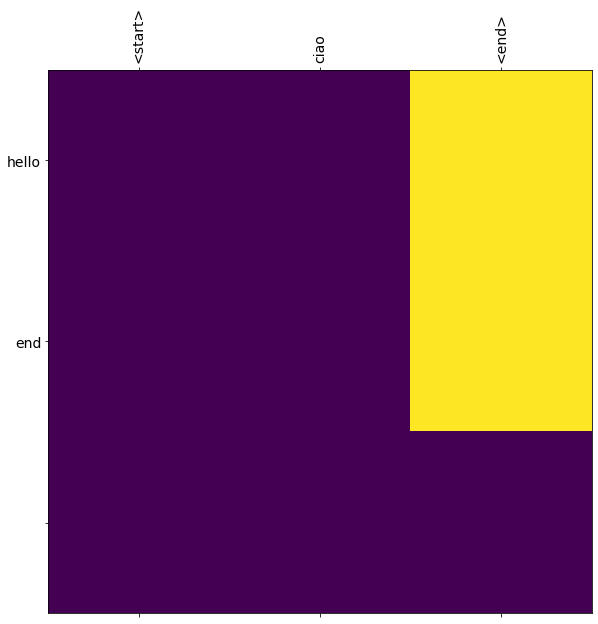

In [ ]:
sent,pred = translate('ciao')

In [ ]:
import nltk.translate.bleu_score as bleu
score = 0
for i in range(1000):
  score = score + bleu.sentence_bleu(data['English'].iloc[i].split(' '), pred)


final_bleu = score/1000

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [ ]:
print(f'final_bleu_score:   {final_bleu}')

final_bleu_score:   0.482982925661091


<h3> Observation 

<h4> Concat score function shows the best result among all the score function i.e  general and dot 